<a href="https://colab.research.google.com/github/tomepm/MiniF2F/blob/main/Ejercicio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 5**
### **Presentado por:** *Pablo Tomé*
**Ejercicio 5:** Elegir uno de entre los siguientes proyectos sugeridos y aplicar clustering para resolverlo. Cada proyecto tiene datasets de diferentes
características y dificultad (indicada con un semaforito). 
Para los más sencillos trabajar individualmente y aplicar más de un método de 
clustering, utilizar diferentes parámetros, comparar evaluaciones. Para los más
complejos, trabajar en grupos de dos personas y aplicar un único modelo. 
Si encuentran algún otro caso de clústering (que no esté totalmente resuelto) lo pueden proponer para negociarlo con la cátedra.

> **Ejercicio 5.1:** **Sommelier de cerveza:** El dataset contiene 1.5 M reportes de cervezas scrappeados del sitio BeerAdvocates. El objetivo es agrupar los tipos de cervezas de acuerdo a dichos reportes, y elegir una de ellas como la mejor representante de cada grupo. *Dificultad: Rojo*

> **Ejercicio 5.2:** **Segmentación de clientes:** El objetivo es encontrar segmentos (grupos) de clientes minoristas en función de su patrón de consumo anual en diversas categorías de productos. *Dificultad: Verde*

> **Ejercicio 5.3:** **Crímenes violentos en los estados de EEUU:** El dataset contiene registros de crímenes ocurridos durante 1973 en EEUU en diferentes estados, así como el porcentaje de la población que vive en zonas urbanas en dichos estados. El objetivo es agrupar a estos estados en diferentes categorías de acuerdo a estos factores. *Dificultad: Verde*

> **Ejercicio 5.4:** **Chatbot**: El objetivo consiste en crear un chatbot utilizando patrones de entrada y respuestas predefinidos. *Dificultad: Amarillo*

**Procedo a elejir el ejercicio 5.3 (Crímenes violentos en los estados de EEUU).** El notebook es https://github.com/manlio99/Materia-de-aprendizaje/tree/master/3_MidtermProjects/ProjectUSA

### **Introducción a los datos**
El dataset contiene información por cada 100000 residentes por agresión (Assault), asesinatos (Murder) y violaciones (Rape) a lo largo de los 50 estados de los EEUU en el año 1973.

**Preparación de librerias**

In [ ]:
# Importación librerias para trabajar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

**Preparación del Datasets**

In [1]:
# Carga del datasets
Df_BCD = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectUSA/data/violent_crime.csv")
Df_BCD.head()

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [2]:
# Renombrado de columnas para mejor identificación
Df_BCD = Df_BCD.rename(columns={
    "Unnamed: 0": "Estado",
    "Murder": "Asesinatos",
    "Assault": "Asaltos",
    "UrbanPop": "PoblacionUrbana",
    "Rape": "Violaciones"
})

# Eliminación de la columna "Estado" para mejor funcionamiento de las estadísticas
Df_BCD = Df_BCD.set_index(Df_BCD['Estado']).drop('Estado', axis=1)
Df_BCD.head()

,asesinatos,asaltos,poblaUrbana,violaciones
state,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [3]:
# Informacion del datasets
Df_BCD.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asesinatos   50 non-null     float64
 1   asaltos      50 non-null     int64  
 2   poblaUrbana  50 non-null     int64  
 3   violaciones  50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [4]:
# Descripcion del dataset
Df_BCD.describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
asaltos,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
poblaUrbana,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
violaciones,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


**Análisis:** Se identifican 2 valores atípicos en las violaciones *(Rape)* pero no se suprime por contener pocos datos.

In [5]:
# Definición de funciones atipicos_columna y atipicos
def atipicos_columna(y, column):
    '''
        Busca y cuenta los atípicos en un vector pasado por parámetro.
        Se basa en el rango intercuartil.
    '''
    # Calcular rango intercuartil
    Df_BCD_y = pd.DataFrame({'y': y})

    q25, q75 = np.percentile(Df_BCD_y['y'], 25), np.percentile(Df_BCD_y['y'], 75)
    iqr = q75 - q25

    # Calcule el rango de valores atípicos
    k = 1.5
    range_ir = iqr * k

    # Límites
    lower_bound_ir, upper_bound_ir = q25 - range_ir, q75 + range_ir

    # Creación de máscaras y búsqueda de atípicos y no atípicos
    outliers_mask_ir = [True if x < lower_bound_ir or x > upper_bound_ir else False for x in Df_BCD_y['y']]
    no_outliers_mask_ir = [False if x < lower_bound_ir or x > upper_bound_ir else True for x in Df_BCD_y['y']]

    outliers = Df_BCD_y['y'][outliers_mask_ir]
    no_outliers = Df_BCD_y['y'][no_outliers_mask_ir]

    print("-- Columna: ", column, "   \t-->", outliers.shape[0])

def atipicos(Df_BCD, inicio = 0):
    '''
        Busca y cuenta atípicos en todo el DataFrame pasado por parámetro
    '''
    print("Cantidad de atipicos: ")
    for column in Df_BCD.columns[inicio:]:
        atipicos_columna(Df_BCD[column].values, column)

In [6]:
atipicos(Df_BCD)

Cantidad de atipicos: 
-- Columna:  asesinatos    	-> 0
-- Columna:  asaltos    	-> 0
-- Columna:  poblaUrbana    	-> 0
-- Columna:  violaciones    	-> 2


**Visualización de las distribuciones de cada una de las variables**

In [7]:
# Definición de funciones print_hist y print_dataset
def print_hist(data, title, ax):
    '''
        print_hist:
            Función para dibujar el histograma y la distribución de los datos.
    '''
    sns.histplot(data, alpha=0.4, kde=True, ax=ax)
    sns.rugplot(data, color="black", ax=ax)
    
    color = "orange"
    text=f"$\\mu$ = {data.mean():.3f}\n"
    text+=f"$\\sigma$ = {data.std(ddof=1):.3f}"

    bbox = dict(boxstyle='round', fc=color, ec=color, alpha=0.3)
    ax.text(0.72, 0.8, text, fontsize=11, bbox=bbox, transform=ax.transAxes)
    ax.set_title(title)

def print_dataset(Df_BCD, fig_rows, fig_cols):
    '''
        print_dataset:
            Recibe un DataFrame, dibuja sus distribuciones de datos y cuenta cuántos tienen distribución normal
    '''
    cols = Df_BCD.columns
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=((fig_cols*25)//5, (fig_rows*8)//2))
    axes = axes.ravel()

    for col_name, ax in zip(cols, axes):
        print_hist(Df_BCD[col_name], "Distribución de " + col_name, ax)

    fig.tight_layout()
    plt.show()

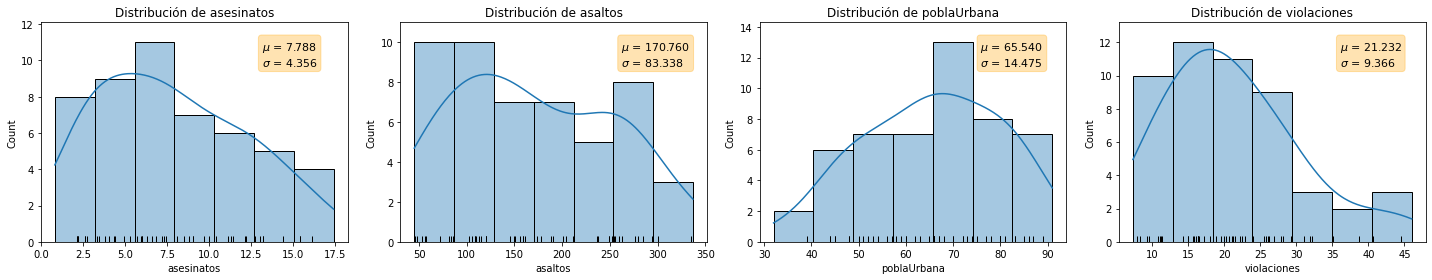

In [8]:
print_dataset(Df_BCD, 1, 4)

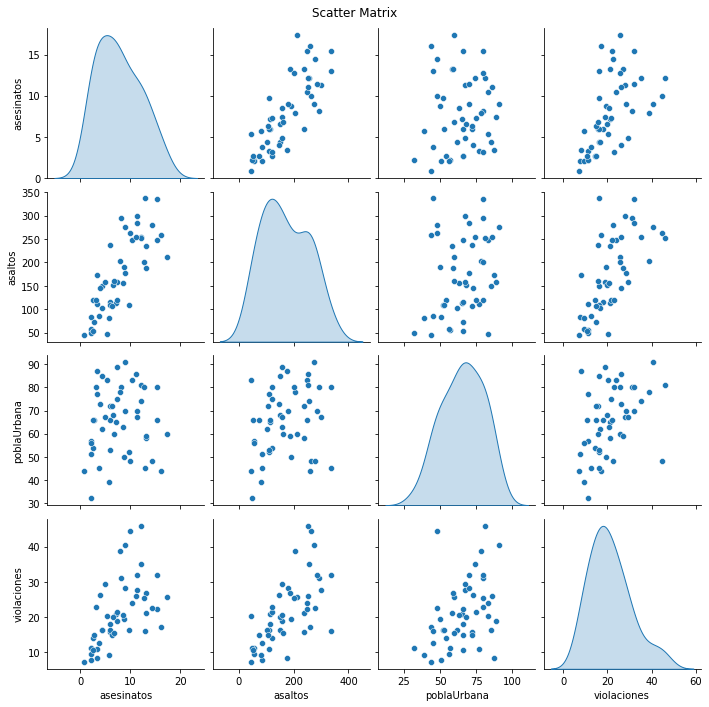

In [9]:
pg = sns.pairplot(data = Df_BCD, diag_kind='kde')
pg.fig.suptitle('Scatter Matrix')
pg.fig.subplots_adjust(top=0.95)

**Observación:** Se puede observar que los asaltos y los asesinatos se encuentran altamente correlacionados. En menor medida las Violaciones están medianamente correlacionados con dichas variables. 

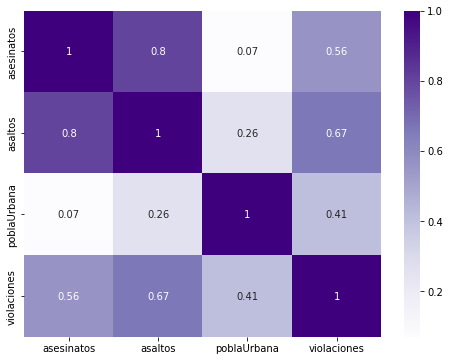

In [10]:
# Determinación de las correlaciones
Df_BCD_corr = Df_BCD.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(Df_BCD_corr, annot=True, cmap="Purples")
plt.show()

### **Escalamiento de los datos**
Dado que el dataset utilizado es pequeño se probarán distintos tipos de escalamientos basados en normalización, estandarizacion, y tres opciones de normalizacion brindadas por *sklearn.preprocessing*.

Se realiza esto con el fin de determinar el efecto del escalamiento en los datos.

In [11]:
# Definición de funciones normalizacion y estandarizacion
def normalizacion(x):
    x = x/x.max()
    return x

def estandarizacion(x):
    x_mean = x.mean()
    x_std = x.std()
    x = (x-x_mean)/x_std
    return x

## **Normalización y Estandarización**

Aplicando normalizacion: 


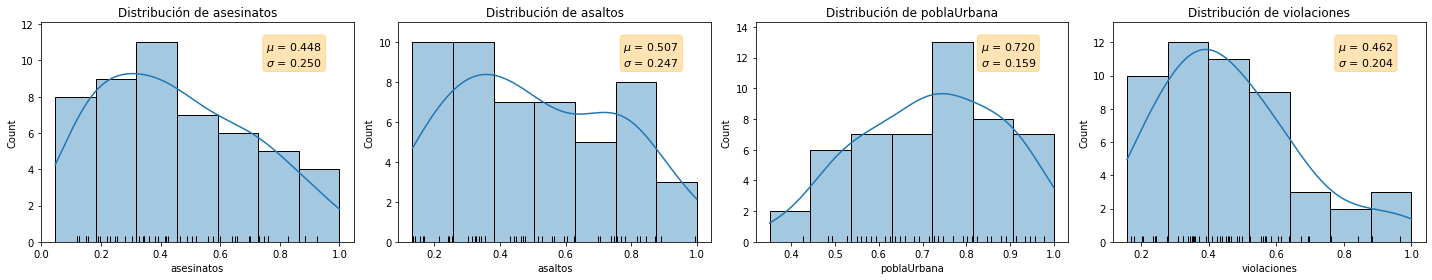

In [12]:
# Normalización
Df_BCD_nor = pd.DataFrame()
for col in Df_BCD.columns:
    Df_BCD_nor[col] = normalizacion(Df_BCD[col])
print("Aplicando Normalizacion: ")
print_dataset(Df_BCD_nor, 1, 4)

Aplicando estandarizacion: 


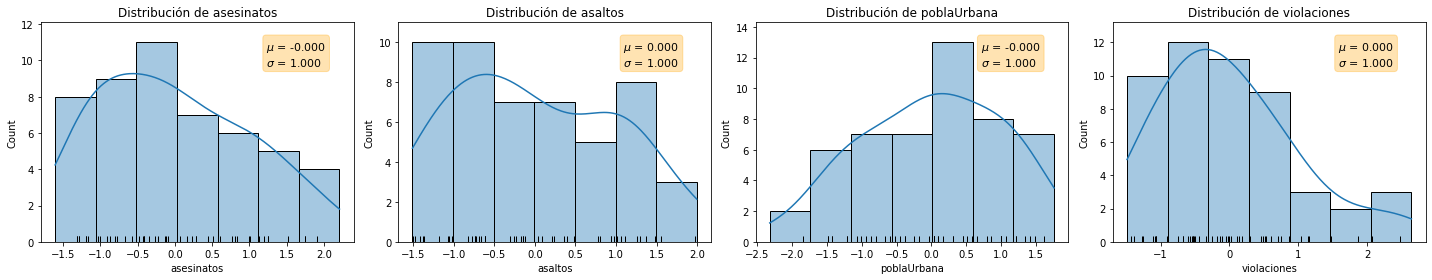

In [13]:
# Estandarización
Df_BCD_est = pd.DataFrame()
for col in Df_BCD.columns:
    Df_BCD_est[col] = estandarizacion(Df_BCD[col])
print("Aplicando Estandarizacion: ")
print_dataset(Df_BCD_est, 1, 4)

Aplicando normalizacion l1: 


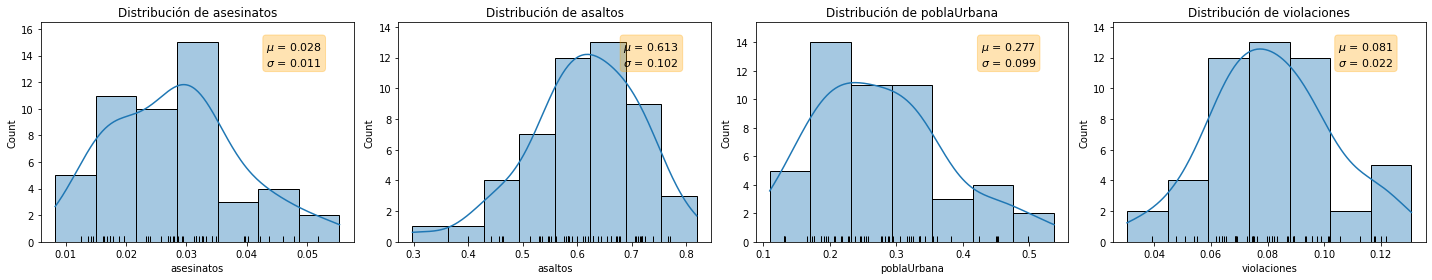

In [14]:
# Normalización l1
Df_BCD_nor_l1 = normalize(Df_BCD, norm="l1")
Df_BCD_nor_l1 = pd.DataFrame(Df_BCD_nor_l1, columns = Df_BCD.columns)
print("Aplicando normalizacion l1: ")
print_dataset(Df_BCD_nor_l1, 1, 4)

Aplicando normalizacion l2: 


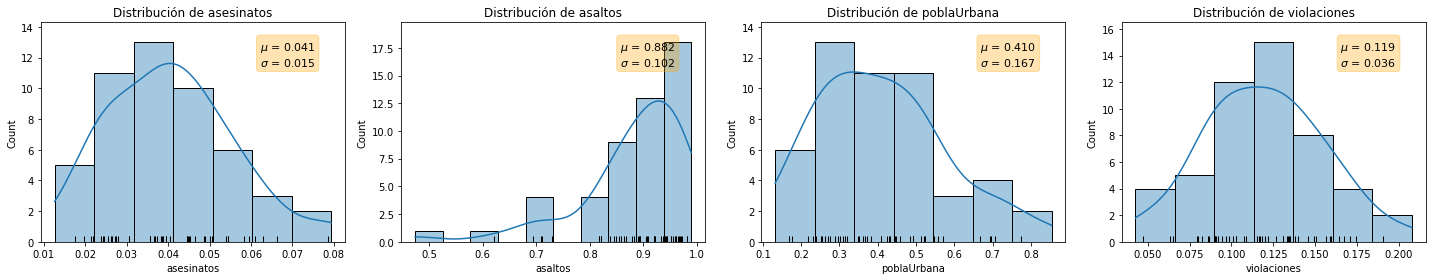

In [15]:
# Normalización l2
Df_BCD_nor_l2 = normalize(Df_BCD, norm="l2")
Df_BCD_nor_l2 = pd.DataFrame(Df_BCD_nor_l2, columns = Df_BCD.columns)
print("Aplicando normalizacion l2: ")
print_dataset(Df_BCD_nor_l2, 1, 4)

Aplicando normalizacion max: 


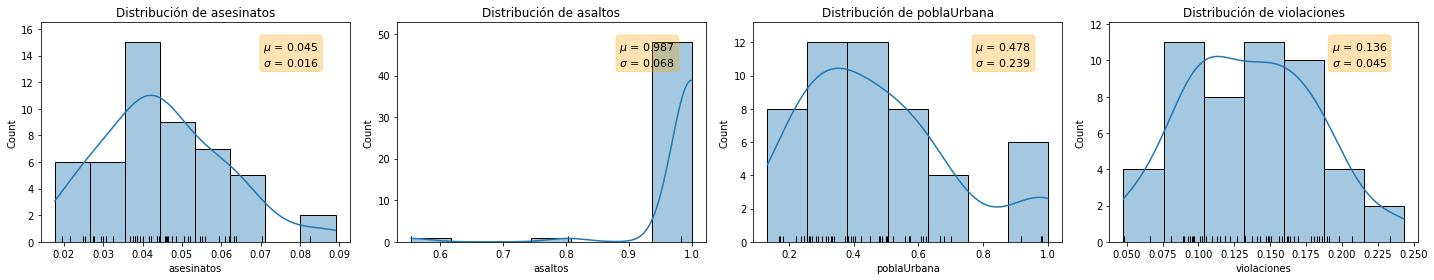

In [16]:
# Normalización máxima
Df_BCD_nor_max = normalize(Df_BCD, norm="max")
Df_BCD_nor_max = pd.DataFrame(Df_BCD_nor_max, columns = Df_BCD.columns)
print("Aplicando normalizacion max: ")
print_dataset(Df_BCD_nor_max, 1, 4)

## **Definicion de modelos**

### **Funciones para la evaluación de los modelos**

In [17]:
# Definición de funciones evaluacion_modelo, buscar_optimo y print_clusters
def evaluacion_modelo(Df_BCD, labels):
    '''
        evaluacion_modelo:
            Funcion que devuelve dos los indices  de Silhoette y Davies Bouldin
            de una agrupacion de datos
    '''
    if labels.shape[0]>1:
        silhouette = silhouette_score(Df_BCD, labels)
        davies_bouldin = davies_bouldin_score(Df_BCD, labels)
    else:
        silhouette = -1
        davies_bouldin = 80
    return (silhouette, davies_bouldin)

def buscar_optimo(conjunto):
    '''
        buscar_optimo:
            Utilizando la funcion evaluacion_modelo devuelve el modelo con mejores
            métricas y realiza un pequeño informe del mismo

            Parametro:
                conjunto = list(
                    DataFrame utilizado (pd.DataFrame), 
                    modelo de clustering (sklearn.cluster), 
                    metricas obtenidas (list(silhouette, davies_bouldin)), 
                    nombre del modelo (str)
                )
            Devuelve:
                Df_BCD_op: una copia del DataFrame utilizado
                model: modelo de clustering óptimo
    '''
    i_op = 0
    sl_op = -1
    db_op = 80
    for i in range(len(conjunto)):
        if conjunto[i][2][0] > sl_op and conjunto[i][2][1] < db_op:
            i_op = i
            sl_op = conjunto[i][2][0]
            db_op = conjunto[i][2][1]

    Df_BCD_op = pd.DataFrame.copy(conjunto[i_op][0])
    model = conjunto[i_op][1]

    print("DataFrame optimo:", conjunto[i_op][-1])
    print("Modelo optimo:", model)
    print("Cantidad de clusters:", np.max(model.labels_) +1)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {sl_op:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {db_op:.3f}")

    return Df_BCD_op, model

def print_clusters(Df_BCD, model, name_model):
    '''
        print_clusters:
            Imprime el ScatterPlot del DataFrame pasado por parámetro
            Pinta con colores los Clusters identificados por el modelo
    '''
    Df_BCD["name_model"] = model.labels_
    Df_BCD[name_model+"_cluster"] = model.labels_
    sns.pairplot(data = Df_BCD, hue = "name_model")
    Df_BCD = Df_BCD.drop("name_model", axis = 1)
    Df_BCD = Df_BCD.drop(name_model+"_cluster", axis = 1)

### **KMeans**

In [18]:
# Definición de función kmeans_model
def kmeans_model(Df_BCD):
    optimo = []
    metricas_optimo = [-1, 80]
    for i in range(2, int(np.sqrt(Df_BCD.shape[0]))):
        kmeans = KMeans(n_clusters=i, random_Estado=0)
        kmeans.fit(Df_BCD)
        metricas = evaluacion_modelo(Df_BCD, kmeans.labels_)
        if metricas[0]>metricas_optimo[0] and metricas[1]<metricas_optimo[1]:
            optimo = kmeans
            metricas_optimo = metricas
    print("Modelo: ", optimo)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {metricas_optimo[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas_optimo[1]:.3f}")
    return optimo, metricas_optimo

#### **Algoritmo con el dataset en sus distintas escalas**

In [19]:
conjunto = []

In [20]:
kmeans, metricas = kmeans_model(Df_BCD)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.593
-- Indice de Davies Bouldin (mejor menor): 0.524


In [21]:
kmeans, metricas = kmeans_model(Df_BCD_nor)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD_nor"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [22]:
kmeans, metricas = kmeans_model(Df_BCD_est)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD_le"))

Modelo:  KMeans(n_clusters=2, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.408
-- Indice de Davies Bouldin (mejor menor): 0.970


In [23]:
kmeans, metricas = kmeans_model(Df_BCD_nor_l1)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD_nor_l1"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.532
-- Indice de Davies Bouldin (mejor menor): 0.567


In [24]:
kmeans, metricas = kmeans_model(Df_BCD_nor_l2)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD_nor_l2"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.543
-- Indice de Davies Bouldin (mejor menor): 0.563


In [25]:
kmeans, metricas = kmeans_model(Df_BCD_nor_max)
conjunto.append((Df_BCD, kmeans, metricas, "Df_BCD_nor_max"))

Modelo:  KMeans(n_clusters=3, random_state=0)
Metricas:
-- Indice de Silhuette (ideal 1): 0.551
-- Indice de Davies Bouldin (mejor menor): 0.569


#### **Mejor modelo junto a su dataset asociado**

DataFrame optimo: df
Modelo optimo: KMeans(n_clusters=2, random_state=0)
Cantidad de clusters: 2
Metricas:
-- Indice de Silhuette (ideal 1): 0.593
-- Indice de Davies Bouldin (mejor menor): 0.524


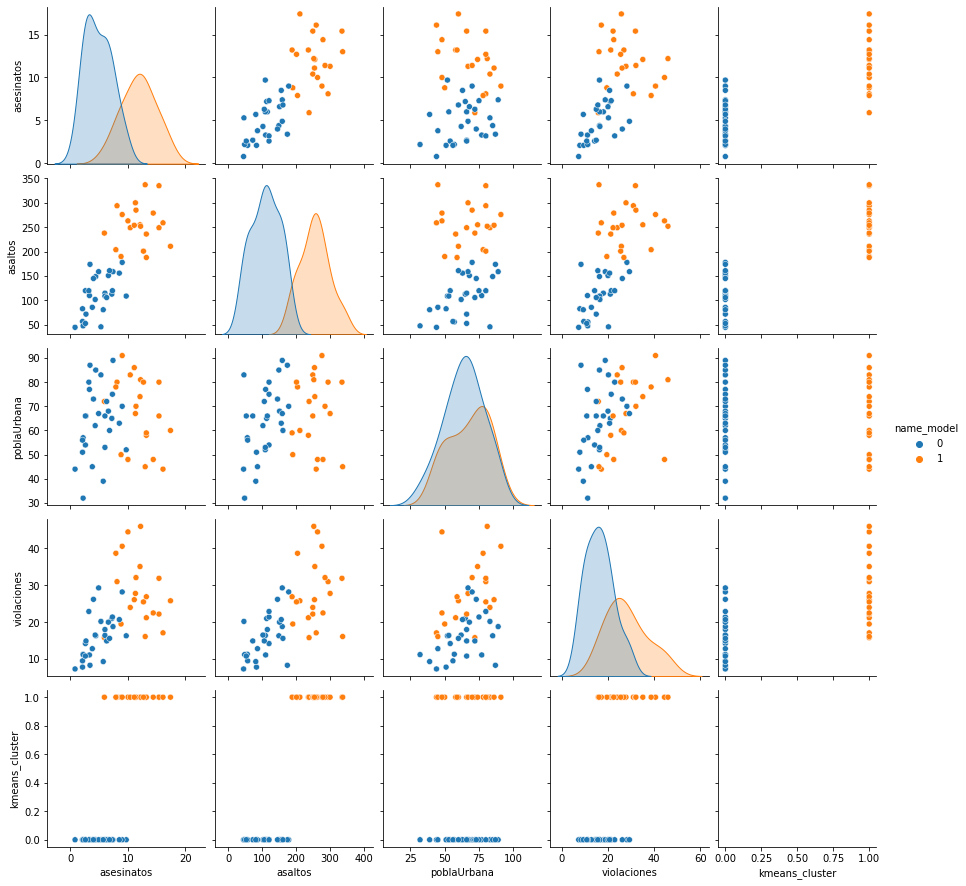

In [26]:
Df_BCD_op, kmeans = buscar_optimo(conjunto)
print_clusters(Df_BCD_op, kmeans, "kmeans")

### **Mean shift**

In [27]:
# Definición de función mean_shift_model
def mean_shift_model(Df_BCD):
    bandwidth = estimate_bandwidth(Df_BCD, quantile=0.3)
    # ms = MeanShift(bandwidth=bandwidth,bin_seeding=True, n_jobs=4)
    ms = MeanShift(bandwidth=bandwidth)
    # ms = MeanShift(bin_seeding=True)
    # ms = MeanShift()
    ms.fit(Df_BCD)

    metricas = evaluacion_modelo(Df_BCD, ms.labels_)
    print("Modelo: ", ms)
    print("Metricas: ")
    print(f"-- Indice de Silhuette (ideal 1): {metricas[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas[1]:.3f}")
    return ms, metricas

#### **Algoritmo con el dataset en sus distintas escalas**

In [28]:
conjunto = []

In [29]:
ms, metricas = mean_shift_model(Df_BCD)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD"))

Modelo:  MeanShift(bandwidth=51.770332099055985)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.511
-- Indice de Davies Bouldin (mejor menor): 0.611


In [30]:
ms, metricas = mean_shift_model(Df_BCD_nor)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD_nor"))

Modelo:  MeanShift(bandwidth=0.38927737549859914)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [31]:
ms, metricas = mean_shift_model(Df_BCD_est)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD_le"))

Modelo:  MeanShift(bandwidth=1.9036598311393156)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.254
-- Indice de Davies Bouldin (mejor menor): 0.987


In [32]:
ms, metricas = mean_shift_model(Df_BCD_nor_l1)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD_nor_l1"))

Modelo:  MeanShift(bandwidth=0.09496581515614817)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.498
-- Indice de Davies Bouldin (mejor menor): 0.455


In [33]:
ms, metricas = mean_shift_model(Df_BCD_nor_l2)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD_nor_l2"))

Modelo:  MeanShift(bandwidth=0.12791194478128404)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.531
-- Indice de Davies Bouldin (mejor menor): 0.434


In [34]:
ms, metricas = mean_shift_model(Df_BCD_nor_max)
conjunto.append((Df_BCD, ms, metricas, "Df_BCD_nor_max"))

Modelo:  MeanShift(bandwidth=0.1596538701934345)
Metricas: 
-- Indice de Silhuette (ideal 1): 0.471
-- Indice de Davies Bouldin (mejor menor): 0.536


#### **Mejor modelo junto a su dataset asociado**

DataFrame optimo: df_l2
Modelo optimo: MeanShift(bandwidth=0.12791194478128404)
Cantidad de clusters: 4
Metricas:
-- Indice de Silhuette (ideal 1): 0.531
-- Indice de Davies Bouldin (mejor menor): 0.434


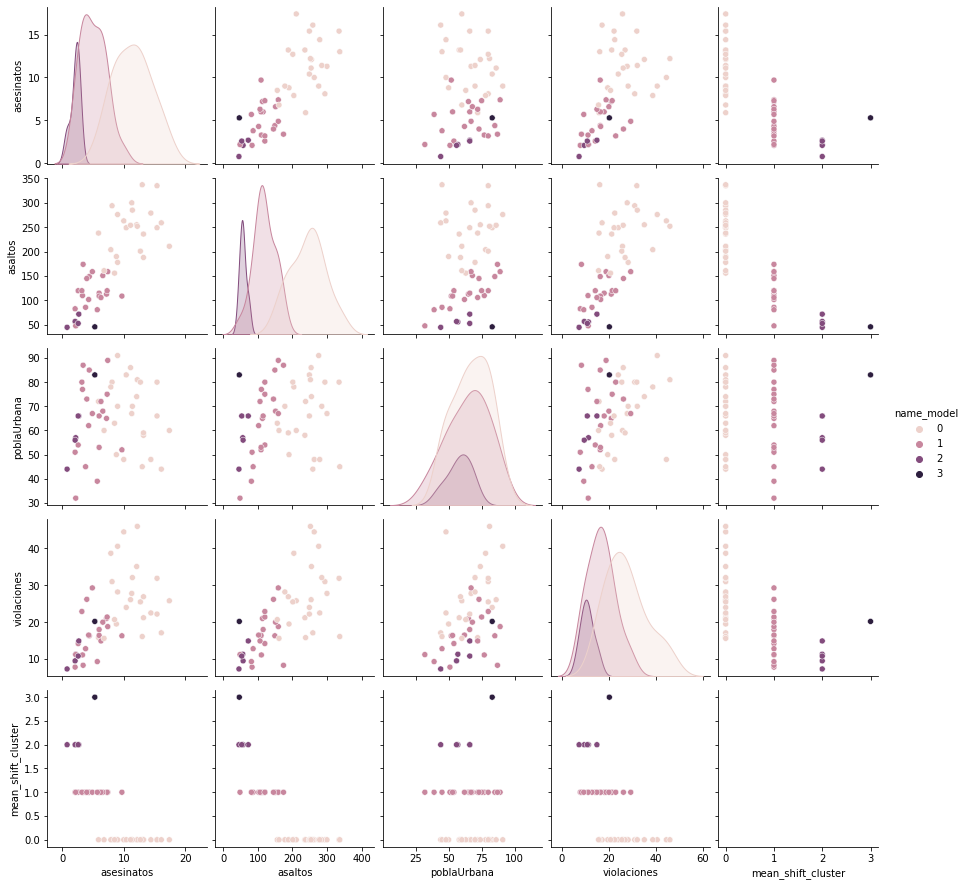

In [35]:
Df_BCD_op, ms = buscar_optimo(conjunto)
print_clusters(Df_BCD_op, ms, "mean_shift")

### **Affinity Propagation**

In [36]:
# Definición de función affinity_propagation_model
def affinity_propagation_model(Df_BCD):
    # ap = AffinityPropagation(random_Estado=5)
    ap = AffinityPropagation()
    ap.fit(Df_BCD)
    metricas = evaluacion_modelo(Df_BCD, ap.labels_)
    print("Modelo: ", ap)
    print("Metricas: ")
    print(f"-- Indice de Silhuette (ideal 1): {metricas[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas[1]:.3f}")
    return ap, metricas

#### **Algoritmo con el dataset en sus distintas escalas**

In [37]:
conjunto = []

In [38]:
ap, metricas = affinity_propagation_model(Df_BCD)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.432
-- Indice de Davies Bouldin (mejor menor): 0.719


In [39]:
ap, metricas = affinity_propagation_model(Df_BCD_nor)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD_nor"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.305
-- Indice de Davies Bouldin (mejor menor): 1.120


In [40]:
ap, metricas = affinity_propagation_model(Df_BCD_est)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD_le"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.311
-- Indice de Davies Bouldin (mejor menor): 1.033


In [41]:
ap, metricas = affinity_propagation_model(Df_BCD_nor_l1)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD_nor_l1"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.430
-- Indice de Davies Bouldin (mejor menor): 0.555


In [42]:
ap, metricas = affinity_propagation_model(Df_BCD_nor_l2)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD_nor_l2"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.385
-- Indice de Davies Bouldin (mejor menor): 0.641


In [43]:
ap, metricas = affinity_propagation_model(Df_BCD_nor_max)
conjunto.append((Df_BCD, ap, metricas, "Df_BCD_nor_max"))

Modelo:  AffinityPropagation()
Metricas: 
-- Indice de Silhuette (ideal 1): 0.486
-- Indice de Davies Bouldin (mejor menor): 0.507


#### **Mejor modelo junto a su dataset asociado**

DataFrame optimo: df_max
Modelo optimo: AffinityPropagation()
Cantidad de clusters: 5
Metricas:
-- Indice de Silhuette (ideal 1): 0.486
-- Indice de Davies Bouldin (mejor menor): 0.507


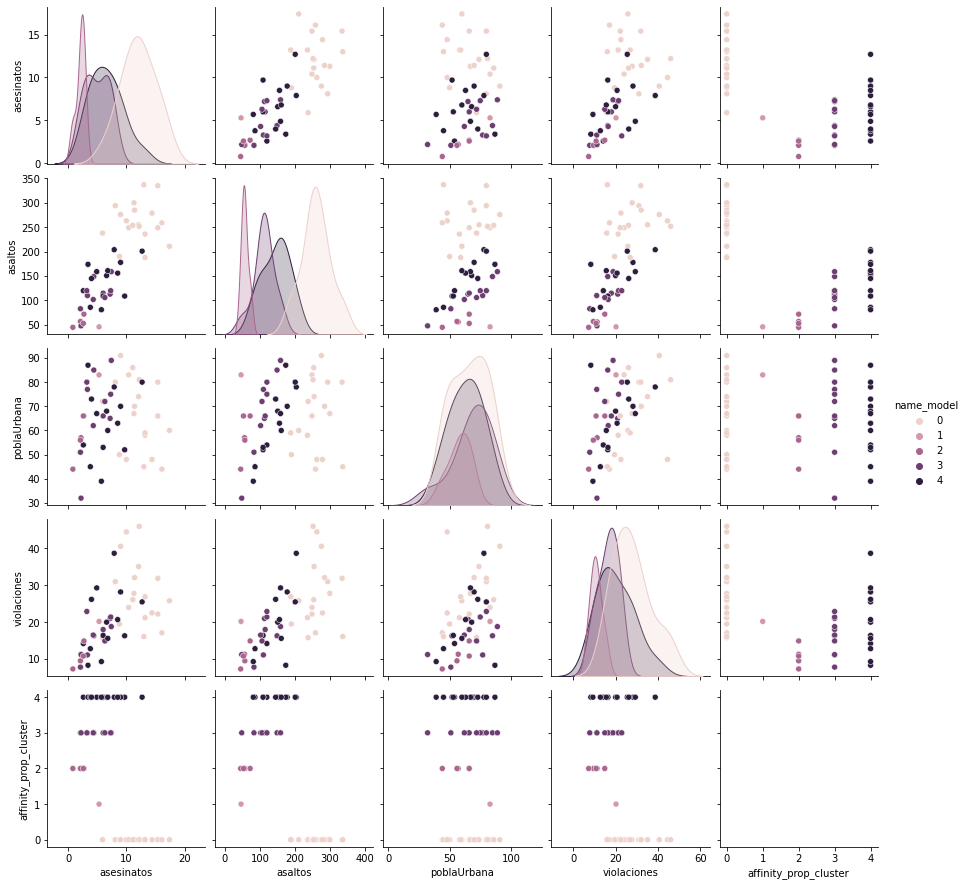

In [44]:
Df_BCD_op, ap = buscar_optimo(conjunto)
print_clusters(Df_BCD_op, ap, "affinity_prop")

### **Agglomerative Clustering**

In [45]:
# Definición de función agglomerative_clustering_model
def agglomerative_clustering_model(Df_BCD):
    optimo = []
    metricas_optimo = [-1, 80]
    for i in range(2, int(np.sqrt(Df_BCD.shape[0]))):
        ac = AgglomerativeClustering(n_clusters=i)
        ac.fit(Df_BCD)
        metricas = evaluacion_modelo(Df_BCD, ac.labels_)
        if metricas[0]>metricas_optimo[0] and metricas[1]<metricas_optimo[1]:
            optimo = ac
            metricas_optimo = metricas
    print("Modelo: ", optimo)
    print("Metricas:")
    print(f"-- Indice de Silhuette (ideal 1): {metricas_optimo[0]:.3f}")
    print(f"-- Indice de Davies Bouldin (mejor menor): {metricas_optimo[1]:.3f}")
    return optimo, metricas_optimo

#### **Algoritmo con el dataset en sus distintas escalas**

In [46]:
conjunto = []

In [47]:
ac, metricas = agglomerative_clustering_model(Df_BCD)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.576
-- Indice de Davies Bouldin (mejor menor): 0.512


In [48]:
ac, metricas = agglomerative_clustering_model(Df_BCD_nor)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD_nor"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.465
-- Indice de Davies Bouldin (mejor menor): 0.828


In [49]:
ac, metricas = agglomerative_clustering_model(Df_BCD_est)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD_le"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.405
-- Indice de Davies Bouldin (mejor menor): 0.980


In [50]:
ac, metricas = agglomerative_clustering_model(Df_BCD_nor_l1)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD_nor_l1"))

Modelo:  AgglomerativeClustering(n_clusters=3)
Metricas:
-- Indice de Silhuette (ideal 1): 0.532
-- Indice de Davies Bouldin (mejor menor): 0.567


In [51]:
ac, metricas = agglomerative_clustering_model(Df_BCD_nor_l2)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD_nor_l2"))

Modelo:  AgglomerativeClustering()
Metricas:
-- Indice de Silhuette (ideal 1): 0.604
-- Indice de Davies Bouldin (mejor menor): 0.481


In [52]:
ac, metricas = agglomerative_clustering_model(Df_BCD_nor_max)
conjunto.append((Df_BCD, ac, metricas, "Df_BCD_nor_max"))

Modelo:  AgglomerativeClustering(n_clusters=3)
Metricas:
-- Indice de Silhuette (ideal 1): 0.542
-- Indice de Davies Bouldin (mejor menor): 0.570


### **Mejor modelo junto a su dataset asociado**

DataFrame optimo: df_l2
Modelo optimo: AgglomerativeClustering()
Cantidad de clusters: 2
Metricas:
-- Indice de Silhuette (ideal 1): 0.604
-- Indice de Davies Bouldin (mejor menor): 0.481


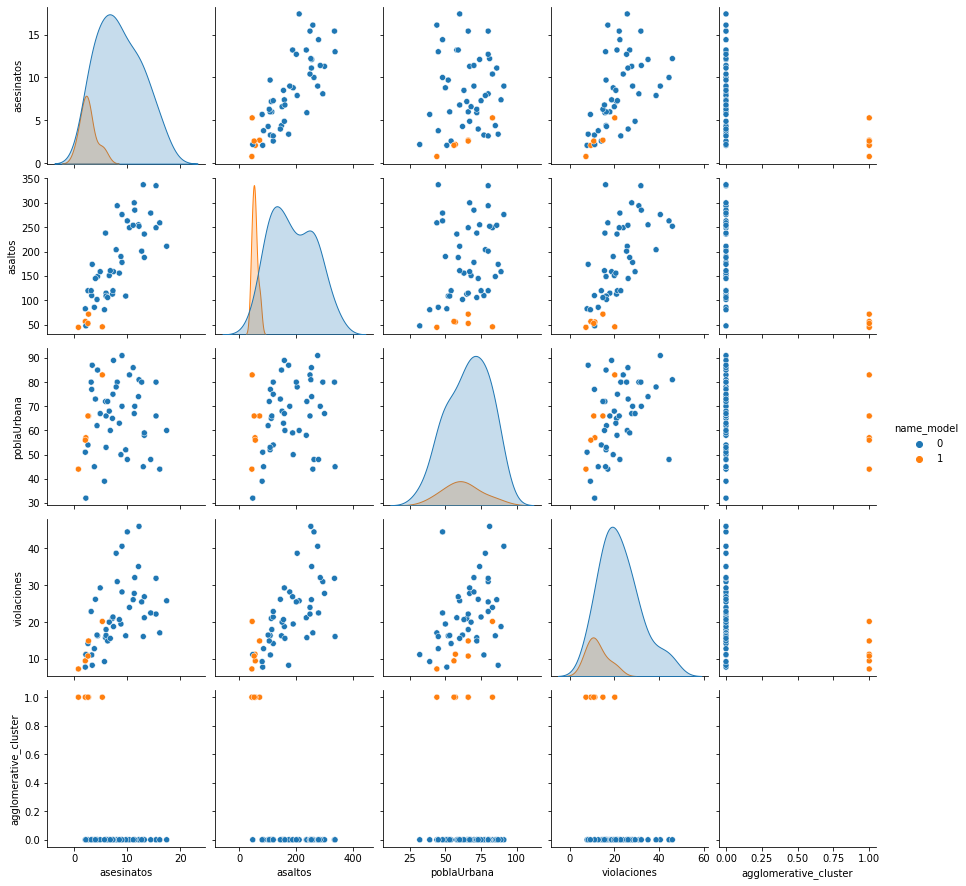

In [53]:
Df_BCD_op, ac = buscar_optimo(conjunto)
print_clusters(Df_BCD_op, ac, "agglomerative")

### **Analisis de la mejor agrupacion de datos**

Como se puede observar, los modelos óptimos de cada uno de los algoritmos difiere en la cantidad de clusters que se deben establecer. Sin embargo, los modelos de *KMeans* y *AgglomerativeClustering* obtienen mejores métricas utilizando solo dos clusters.

Dado que *AgglomerativeClustering* resultó ligeramente mejor que *KMeans*, en esta sección se analiza el agrupamiento realizado por el mismo.

In [54]:
# Agrupación de los datos originales
Df_BCD_op = pd.DataFrame.copy(Df_BCD) 
Df_BCD_op['label'] = ac.labels_

Df_BCD_op = Df_BCD_op.set_index(Df_BCD.index)

In [55]:
Df_BCD_op[(Df_BCD_op['label']==0)]

,asesinatos,asaltos,poblaUrbana,violaciones,label
state,,,,,
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,0
Arkansas,8.8,190,50,19.5,0
California,9.0,276,91,40.6,0
Colorado,7.9,204,78,38.7,0
Connecticut,3.3,110,77,11.1,0
Delaware,5.9,238,72,15.8,0
Florida,15.4,335,80,31.9,0


In [56]:
# Descripcion del dataset
Df_BCD_op[(Df_BCD_op['label']==0)].describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,44.0,8.493182,4.137936,2.1,5.50,8.0,11.575,17.4
asaltos,44.0,186.568182,75.975026,48.0,118.75,176.0,252.500,337.0
poblaUrbana,44.0,66.022727,14.724586,32.0,53.75,67.0,78.500,91.0
violaciones,44.0,22.445455,9.217740,7.8,16.25,21.1,27.125,46.0
label,44.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


In [57]:
Df_BCD_op[(Df_BCD_op['label']==1)]

,asesinatos,asaltos,poblaUrbana,violaciones,label
state,,,,,
Hawaii,5.3,46,83,20.2,1
Iowa,2.2,56,57,11.3,1
Minnesota,2.7,72,66,14.9,1
New Hampshire,2.1,57,56,9.5,1
North Dakota,0.8,45,44,7.3,1
Wisconsin,2.6,53,66,10.8,1


In [58]:
# Descripcion del dataset
Df_BCD_op[(Df_BCD_op['label']==1)].describe().T

,count,mean,std,min,25%,50%,75%,max
asesinatos,6.0,2.616667,1.479752,0.8,2.125,2.40,2.675,5.3
asaltos,6.0,54.833333,9.786044,45.0,47.750,54.50,56.750,72.0
poblaUrbana,6.0,62.000000,13.099618,44.0,56.250,61.50,66.000,83.0
violaciones,6.0,12.333333,4.588101,7.3,9.825,11.05,14.000,20.2
label,6.0,1.000000,0.000000,1.0,1.000,1.00,1.000,1.0


**Conclusión:** a pesar de no obtener las mejores métricas, se puede ver que el algoritmo ha diferenciado entre dos grupos de estados. Uno bastante grande de 44 estados (cluster 0) y otro de solo 6 estados (cluster 1). Los primeros están caracterizados por tener indices de violencia más altos en comparación de los estados más "tranquilos".

Es posible ver también que el indice promedio de población urbana es apenas menor en los "tranquilos", por lo que no significaría un indicador de violencia.